  # Importowanie bibliotek

In [ ]:
import numpy as np
from sklearn.datasets import make_classification,make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix
from scipy import stats
from scipy.optimize import minimize

from sklearn.tree import DecisionTreeClassifier
iterations=100
def log_classifier_time(func): #Dekorator do mierzenia czasu klasyfikowania 
    def wrapper(*args,**kwargs):
        start_time=time.time()
        for _ in range(iterations):
            result=func(*args,**kwargs)
        end_time=time.time()-start_time
        print(f"Czas wykonywania {iterations} iteracji wyniósł {end_time:.6f} sekund")
        return result
    return wrapper
def display_classifier_details(y_pred,y_test,name):
    tn, fp, fn, tp=confusion_matrix(y_test,y_pred).ravel()
    sensitivity=tp/(tp+fp)
    specificity=tn/(tn+fn)

    print(f"""\t{name}\n
          \taccuracy: {accuracy_score(y_test,y_pred)}\n
          \tsensitivity: {sensitivity}\n
          \tspecificity: {specificity}
        """)
def plot_roc_curve(y_test,y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'Krzywa ROC - AUC={roc_auc}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.title("Krzywa ROC")
    plt.show()
def plot_decision_boundary(X_test,y_test,clf,title="",pandas=False):
    if not pandas:
        x_min,x_max=X_test[:,0].min(),X_test[:,0].max()
        y_min,y_max=X_test[:,1].min(),X_test[:,1].max()
    else:
        x_min,x_max=X_test.iloc[:,0].min(),X_test.iloc[:,0].max()
        y_min,y_max=X_test.iloc[:,1].min(),X_test.iloc[:,1].max()
    num=1000
    xx,yy=np.meshgrid(np.linspace(x_min,x_max,num),np.linspace(y_min,y_max,num))

    Z=clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape((num,num))
    plt.title(title)
    y_=np.where(y_test>0,1,-1)
    plt.contourf(xx,yy,Z)
    plt.scatter(X_test[:,0],X_test[:,1],c=y_,edgecolors="black")
    plt.show()

 # Zadanie na 3 - przygotowanie próbek

In [ ]:
n_samples=2544
X,t=make_classification(n_samples=n_samples,n_features=2,n_informative=2,n_redundant=0,n_clusters_per_class=1,random_state=254479)
X_moons,t_moons=make_moons(n_samples=n_samples,random_state=254479)
X_train,X_test,y_train,y_test=train_test_split(X,t)
X_train_moons,X_test_moons,y_train_moons,y_test_moons=train_test_split(X_moons,t_moons)

#Zbiór wielmodowy
X2,t2=make_classification(n_samples=n_samples,n_features=2,n_informative=2,n_redundant=0,n_clusters_per_class=2,random_state=254479)
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,t2)
#Standaryzacja
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X_train_moons=scaler.fit_transform(X_train_moons)
X_test_moons=scaler.transform(X_test_moons)

X2_train=scaler.fit_transform(X2_train)
X2_test=scaler.transform(X2_test)

 # Zadanie na 3 - własna implementacja drzewa decyzyjnego

<ipython-input-43-b36124eeb0d6>:62: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-43-b36124eeb0d6>:62: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Własna implementacja drzewa decyzyjnego

          	accuracy: 0.9811320754716981

          	sensitivity: 0.9967320261437909

          	specificity: 0.9666666666666667
        
None


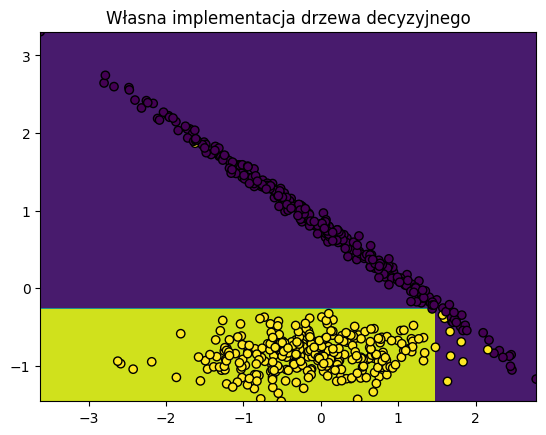

<ipython-input-43-b36124eeb0d6>:62: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-43-b36124eeb0d6>:62: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Własna implementacja drzewa decyzyjnego

          	accuracy: 0.8317610062893082

          	sensitivity: 1.0

          	specificity: 0.7482352941176471
        
None


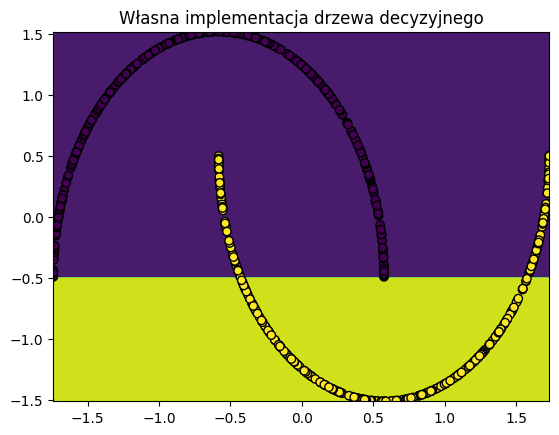

<ipython-input-43-b36124eeb0d6>:62: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-43-b36124eeb0d6>:62: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Własna implementacja drzewa decyzyjnego dla zbioru wielmodowego

          	accuracy: 0.8710691823899371

          	sensitivity: 0.856687898089172

          	specificity: 0.8850931677018633
        
None


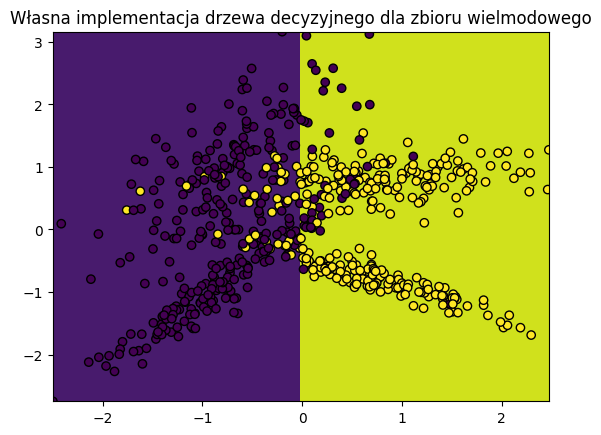

In [ ]:
class MyDecisionTreeClassifier:
    class Node:
        def __init__(self,value=None,left=None,right=None,feature=None,threshold=None) -> None:
            self.value=value
            self.left=left
            self.right=right
            self.feature=feature
            self.threshold=threshold
    
    def __init__(self,max_depth=2) -> None:
        self.max_depth=max_depth

    def fit(self, X_train,y_train):
        self.tree=self.build_decision_tree(X_train,y_train)
    def build_decision_tree(self,X,y,i=0):
       
        if i>=self.max_depth or len(y)<2:
            return self.Node(value=self._most_common(y))
        
        feature,threshold=self._best_split(X,y)
        left,right=self._split(X[:,feature],threshold)
        left_node=self.build_decision_tree(X[left],y[left],i+1)
        right_node=self.build_decision_tree(X[right],y[right],i+1)
        node=self.Node()
        node.feature=feature
        node.threshold=threshold
        node.left=left_node
        node.right=right_node
        return node
    
    def _information_gain(self,X,y,threshold):
        parent_entropy=self._entropy(y)
        left,right=self._split(X,threshold)

        left_entropy=self._entropy(y[left])
        right_entropy=self._entropy(y[right])

        return parent_entropy - len(left)/len(y)*left_entropy - len(right)/len(y)*right_entropy

    def _best_split(self,X,y):
        best_gain=0
        feature=0
        threshold=0
        for i in range(X.shape[1]):
            X[:,i]
            thresholds=np.unique(X[:,i])
            for t in thresholds:
                if (ig:=self._information_gain(X[:,i],y,t))>best_gain:
                    best_gain=ig
                    feature=i
                    threshold=t

        return feature,threshold    


    def _most_common(self,elements):
        el,counts=np.unique(elements,return_counts=True)
        return el[np.argmax(counts)]
    
    def _entropy(self,y):
        p=np.bincount(y)/len(y)
        return -np.sum([np.log(pi)*pi for pi in p ])  
    
    def _split(self,X,threshold):
        left=np.argwhere(X<=threshold).flatten()
        right=np.argwhere(X>threshold).flatten()
        return left,right
    
    def predict(self,X_test):
        result=[]
        for x in X_test:
            node=self.tree
            while node.value==None:
                if x[node.feature]<node.threshold:
                    node=node.left
                else:
                    node=node.right
            result.append(node.value)


        return np.array(result)         

#Zbiór jednomodowy

clf=MyDecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)   

print(display_classifier_details(y_pred,y_test,"Własna implementacja drzewa decyzyjnego"))
plot_decision_boundary(X_test,y_test,clf,"Własna implementacja drzewa decyzyjnego")

#Moons

clf=MyDecisionTreeClassifier()
clf.fit(X_train_moons,y_train_moons)
y_pred_moons=clf.predict(X_test_moons)   

print(display_classifier_details(y_pred_moons,y_test_moons,"Własna implementacja drzewa decyzyjnego"))
plot_decision_boundary(X_test_moons,y_test_moons,clf,"Własna implementacja drzewa decyzyjnego")

#Zbiór wielomodowy
clf=MyDecisionTreeClassifier()
clf.fit(X2_train,y2_train)
y2_pred=clf.predict(X2_test)   

print(display_classifier_details(y2_pred,y2_test,"Własna implementacja drzewa decyzyjnego dla zbioru wielmodowego"))
plot_decision_boundary(X2_test,y2_test,clf,"Własna implementacja drzewa decyzyjnego dla zbioru wielmodowego")

 # Zadanie na 3 - scikitowa implementacja drzewa decyzyjnego
 Zbiór jednomodowy

	DecisionTreeClassifier z sklearn

          	accuracy: 0.9842767295597484

          	sensitivity: 0.9841772151898734

          	specificity: 0.984375
        


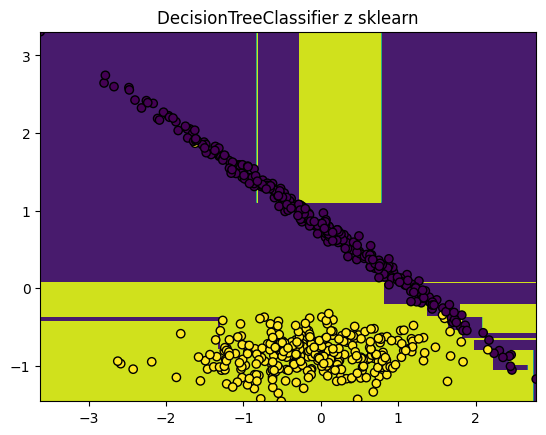

	DecisionTreeClassifier z sklearn dla moons

          	accuracy: 1.0

          	sensitivity: 1.0

          	specificity: 1.0
        


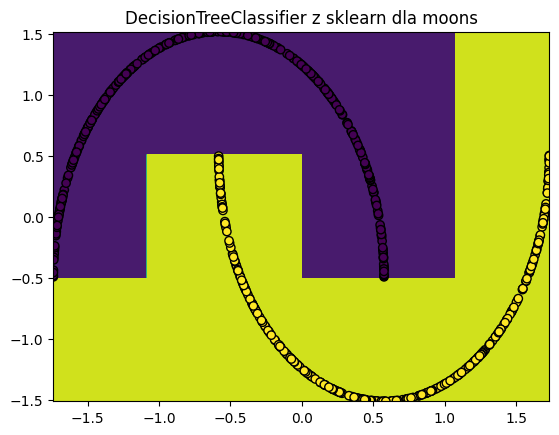

	DecisionTreeClassifier z sklearn dla zbioru wielmodowego

          	accuracy: 0.8679245283018868

          	sensitivity: 0.8490566037735849

          	specificity: 0.8867924528301887
        
None


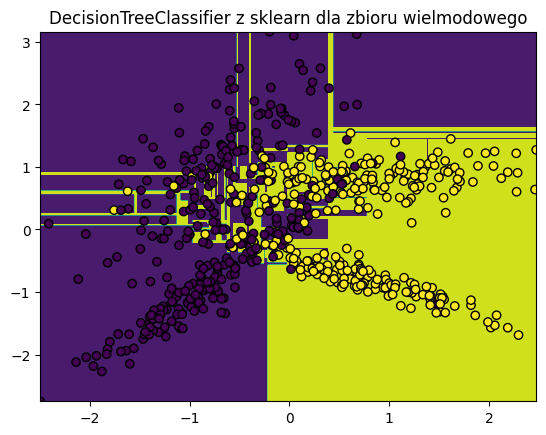

In [ ]:
clf=DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

display_classifier_details(y_pred,y_test,"DecisionTreeClassifier z sklearn")
plot_decision_boundary(X_test,y_test,clf,"DecisionTreeClassifier z sklearn")

#Moons
clf=DecisionTreeClassifier()
clf.fit(X_train_moons,y_train_moons)
y_pred_moons=clf.predict(X_test_moons)

display_classifier_details(y_pred_moons,y_test_moons,"DecisionTreeClassifier z sklearn dla moons")
plot_decision_boundary(X_test_moons,y_test_moons,clf,"DecisionTreeClassifier z sklearn dla moons")


#Zbiór wielomodowy
clf=DecisionTreeClassifier()
clf.fit(X2_train,y2_train)
y2_pred=clf.predict(X2_test)   

print(display_classifier_details(y2_pred,y2_test,"DecisionTreeClassifier z sklearn dla zbioru wielmodowego"))
plot_decision_boundary(X2_test,y2_test,clf,"DecisionTreeClassifier z sklearn dla zbioru wielmodowego")

 # Zadanie na 3 - scikitowa implementacja drzewa decyzyjnego
 Zbiór jednomodowy

	DecisionTreeClassifier z sklearn

          	accuracy: 0.9827044025157232

          	sensitivity: 0.9810725552050473

          	specificity: 0.9843260188087775
        


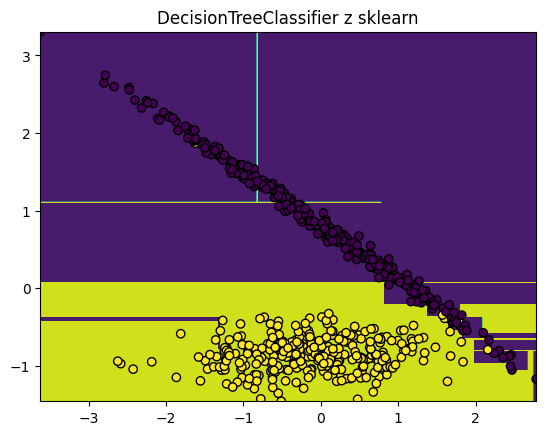

	DecisionTreeClassifier z sklearn dla moons

          	accuracy: 0.9182389937106918

          	sensitivity: 1.0

          	specificity: 0.8594594594594595
        


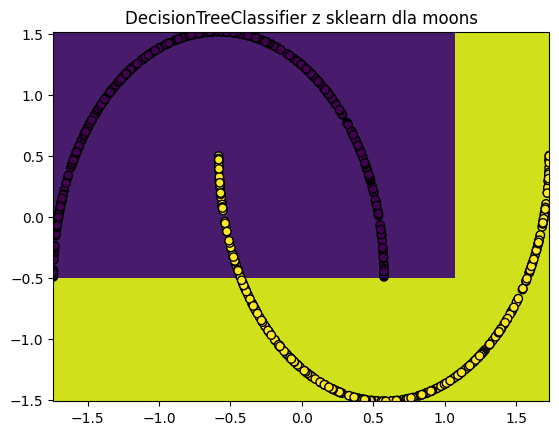

	DecisionTreeClassifier z sklearn dla zbioru wielmodowego

          	accuracy: 0.8710691823899371

          	sensitivity: 0.856687898089172

          	specificity: 0.8850931677018633
        
None


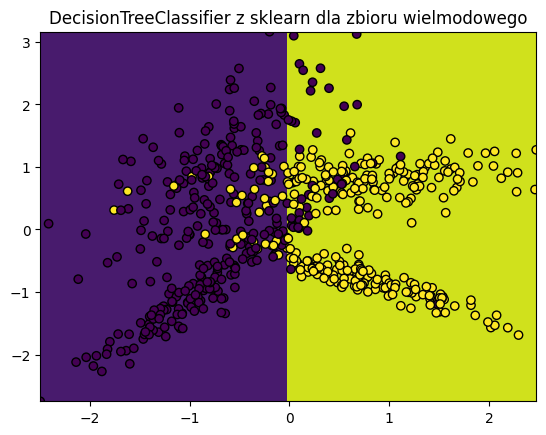

In [ ]:
clf=DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

display_classifier_details(y_pred,y_test,"DecisionTreeClassifier z sklearn")
plot_decision_boundary(X_test,y_test,clf,"DecisionTreeClassifier z sklearn")

#Moons
clf=DecisionTreeClassifier(max_depth=2)
clf.fit(X_train_moons,y_train_moons)
y_pred_moons=clf.predict(X_test_moons)

display_classifier_details(y_pred_moons,y_test_moons,"DecisionTreeClassifier z sklearn dla moons")
plot_decision_boundary(X_test_moons,y_test_moons,clf,"DecisionTreeClassifier z sklearn dla moons")


#Zbiór wielomodowy
clf=DecisionTreeClassifier(max_depth=2)
clf.fit(X2_train,y2_train)
y2_pred=clf.predict(X2_test)   

print(display_classifier_details(y2_pred,y2_test,"DecisionTreeClassifier z sklearn dla zbioru wielmodowego"))
plot_decision_boundary(X2_test,y2_test,clf,"DecisionTreeClassifier z sklearn dla zbioru wielmodowego")

 # Zadanie na 4 - preprocessing danych

In [ ]:
from sklearn.model_selection import GridSearchCV
data=pd.read_csv('HTRU_2.csv',header=None)
X=data.iloc[:,:-1]
t=data.iloc[:,-1]
scaler=StandardScaler()
X=scaler.fit_transform(X)

In [ ]:
clf=DecisionTreeClassifier()
GridSearchCV(clf,{
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}).fit(X,t)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'min_samples_split': [2, 5, 10]})

In [ ]:
clf=DecisionTreeClassifier()
gs=GridSearchCV(clf,{
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}).fit(X,t)

In [ ]:
gs

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'min_samples_split': [2, 5, 10]})

 #Zadanie na 4 - najlepsze parametry

In [ ]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

 #Zadanie na 4 - klasyfikacja z najlepszymi parametrami

	Klasyfikator dla HTRU2

          	accuracy: 0.9805586592178771

          	sensitivity: 0.9168975069252078

          	specificity: 0.9861448711716091
        


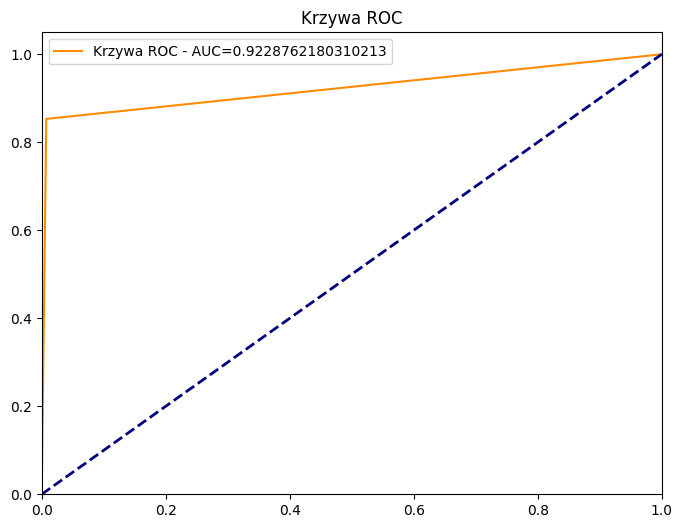

In [ ]:
clf=DecisionTreeClassifier(criterion='gini',  max_depth=30,min_samples_leaf=10,min_samples_split=10)
X_train,X_test,y_train,y_test=train_test_split(X,t)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

display_classifier_details(y_pred,y_test,"Klasyfikator dla HTRU2")
plot_roc_curve(y_test,y_pred)

 # Zadanie na 5 - porównanie głębokości, własna implementacja

In [ ]:
depths=range(2,5)
times=10
for i in depths:
    start=time.time()
    for _ in range(times):
        clf=MyDecisionTreeClassifier(max_depth=i)
        clf.fit(X_train,np.array(y_train))
        y_pred=clf.predict(X_test)
        display_classifier_details(y_pred,y_test,"Klasyfikator dla HTRU2")
    end=time.time()-start
    print(f"Dla głębokośći={i} i {times} powtórzeń wykonano w czasie {end}s")

<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        
Dla głębokośći=2 i 10 powtórzeń wykonano w czasie 400.4182937145233s


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9789944134078212

          	sensitivity: 0.9106145251396648

          	specificity: 0.9849404906485305
        
Dla głębokośći=3 i 10 powtórzeń wykonano w czasie 538.0733449459076s


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        


<ipython-input-96-408494336b3a>:61: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(pi)*pi for pi in p ])
<ipython-input-96-408494336b3a>:61: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([np.log(pi)*pi for pi in p ])


	Klasyfikator dla HTRU2

          	accuracy: 0.9796648044692737

          	sensitivity: 0.9183098591549296

          	specificity: 0.9849514563106796
        
Dla głębokośći=4 i 10 powtórzeń wykonano w czasie 650.5932424068451s


 # Zadanie na 5 porównanie głębokości - scikitowa implementacja

In [ ]:
for i in depths:
    start=time.time()
    for _ in range(times):
        clf=DecisionTreeClassifier(max_depth=i)
        clf.fit(X_train,np.array(y_train))
        y_pred=clf.predict(X_test)
    display_classifier_details(y_pred,y_test,"Klasyfikator dla HTRU2")

    end=time.time()-start
    print(f"Dla głębokośći={i} i {times} powtórzeń wykonano w czasie {end}s")

	Klasyfikator dla HTRU2

          	accuracy: 0.9792178770949721

          	sensitivity: 0.9131652661064426

          	specificity: 0.9849441476444876
        
Dla głębokośći=2 i 10 powtórzeń wykonano w czasie 0.3802628517150879s
	Klasyfikator dla HTRU2

          	accuracy: 0.9805586592178771

          	sensitivity: 0.9123287671232877

          	specificity: 0.98661800486618
        
Dla głębokośći=3 i 10 powtórzeń wykonano w czasie 0.4942626953125s
	Klasyfikator dla HTRU2

          	accuracy: 0.982122905027933

          	sensitivity: 0.9450867052023122

          	specificity: 0.9852264470816178
        
Dla głębokośći=4 i 10 powtórzeń wykonano w czasie 0.6967897415161133s


#%%[markdown]

 # Zbiór wielomodowy

	DecisionTreeClassifier z sklearn dla zbioru wielmodowego

          	accuracy: 0.8584905660377359

          	sensitivity: 0.8206686930091185

          	specificity: 0.8990228013029316
        
None


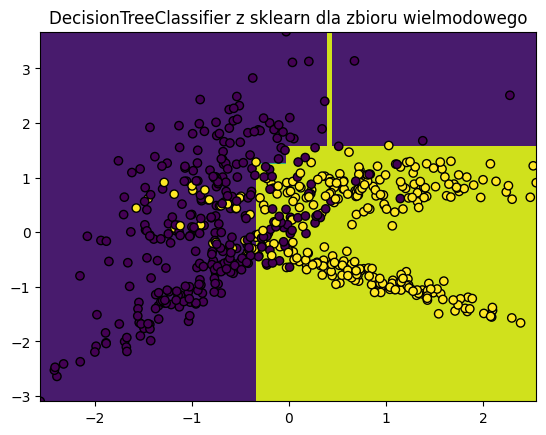

In [ ]:
clf=DecisionTreeClassifier(max_depth=4)
clf.fit(X2_train,y2_train)
y2_pred=clf.predict(X2_test)   

print(display_classifier_details(y2_pred,y2_test,"DecisionTreeClassifier z sklearn dla zbioru wielmodowego"))
plot_decision_boundary(X2_test,y2_test,clf,"DecisionTreeClassifier z sklearn dla zbioru wielmodowego")